In [1]:
import xarray as xr
import urllib.request

path_to_file = 'data/sea_ice_extent.nc'
urllib.request.urlretrieve('https://thredds.met.no/thredds/fileServer/osisaf/met.no/ice/index/v2p1/nh/osisaf_nh_sie_monthly.nc', path_to_file) 

with xr.open_dataset(path_to_file) as sea_ice_extent:
    pass

sea_ice_extent


<xarray.Dataset>
Dimensions:        (time: 532, nv: 2)
Coordinates:
  * time           (time) datetime64[ns] 1979-01-16 1979-02-16 ... 2023-04-16
    sic_threshold  float32 ...
    lat            float32 ...
    lon            float32 ...
Dimensions without coordinates: nv
Data variables:
    time_bounds    (time, nv) datetime64[ns] ...
    lat_bounds     (nv) float32 ...
    lon_bounds     (nv) float32 ...
    area           |S2 ...
    sie            (time) float64 ...
Attributes: (12/33)
    title:                   Monthly Mean Northern Hemisphere Sea Ice Extent ...
    product_id:              OSI-420
    product_name:            OSI SAF Sea Ice Index
    product_status:          demonstration
    version:                 v2p1
    summary:                 Time series of Monthly Mean Sea Ice Extent (SIE)...
    ...                      ...
    publisher_url:           met.no
    project:                 EUMETSAT OSI SAF
    distribution_statement:  Free
    copyright_statement:     Copyright 2023 EUMETSAT
    references:              Product User Manual for OSI-420, Lavergne et al....
    featureType:             timeSeries

In [2]:
extent = sea_ice_extent['sie']

label_months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

Text(0.0, 1.0, 'Arctic sea ice extent (million km$^2$)')

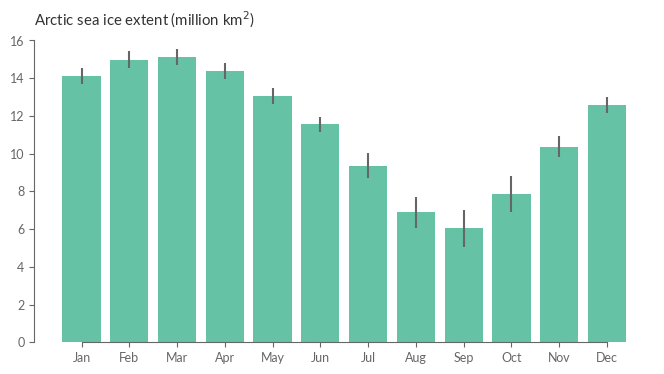

In [3]:
extent_clim = extent.sel(time=slice('1991', '2020'))
extent_clim_mean = extent_clim.groupby('time.month').mean()
extent_clim_stdev = extent_clim.groupby('time.month').std()

frac_ext = extent_clim_mean / extent_clim_mean.max()
import numpy as np
percentages = np.linspace(0, 120, 7)
yticks = percentages * extent_clim_mean.max().values / 100

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('../copernicus.mplstyle')

fig, ax = plt.subplots(1,1, figsize=(8,4))
ax.bar(extent_clim_mean.month, extent_clim_mean, yerr=extent_clim_stdev, ecolor='.4')
ax.set_xticks(extent_clim_mean.month)
ax.set_xticklabels(label_months)
sns.despine(ax=ax, trim=True)
ax.set_title('Arctic sea ice extent (million km$^2$)')



In [4]:
extent2 = extent.assign_coords(year=extent.time.dt.year, month=extent.time.dt.month)
# Stack year and month into a new multi-index
extent2 = extent2.set_index(time=['year', 'month'])



Text(0.0, 1.0, 'Arctic sea ice extent (million km$^2$)')

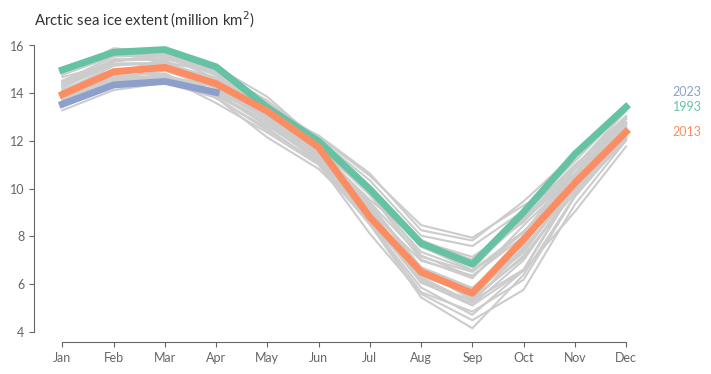

In [5]:
# get a different color for each year using a sequential colormap
prop_cycle_clrs = plt.rcParams['axes.prop_cycle']
colors = prop_cycle_clrs.by_key()['color']
special_years = [1993, 2013, 2023]
special_colors = {year: clr for year, clr in zip(special_years, colors[:len(special_years)])}

fig, ax = plt.subplots(1,1, figsize=(8,4))
for year in range(1991, 2024):
    extent2.sel(year=year).plot(ax=ax, color='.8')
    if year in special_years:
        clr = special_colors[year]
        extent2.sel(year=year).plot(ax=ax, color=clr, lw=5, label=year, zorder=3)

ax.set_xticks(extent_clim_mean.month)
ax.set_xticklabels(label_months)
import matplotx
matplotx.line_labels(ax=ax) # add legend as colored text next to the right end of the relevant line
sns.despine(ax=ax, trim=True)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Arctic sea ice extent (million km$^2$)')

In [6]:
extent_anom = (extent.groupby('time.month') - extent_clim_mean).groupby('time.month') / extent_clim_mean
is_march = extent_anom.month == 3
is_september = extent_anom.month == 9

anom_march = extent_anom.sel(time=is_march) * 100
anom_september = extent_anom.sel(time=is_september) * 100

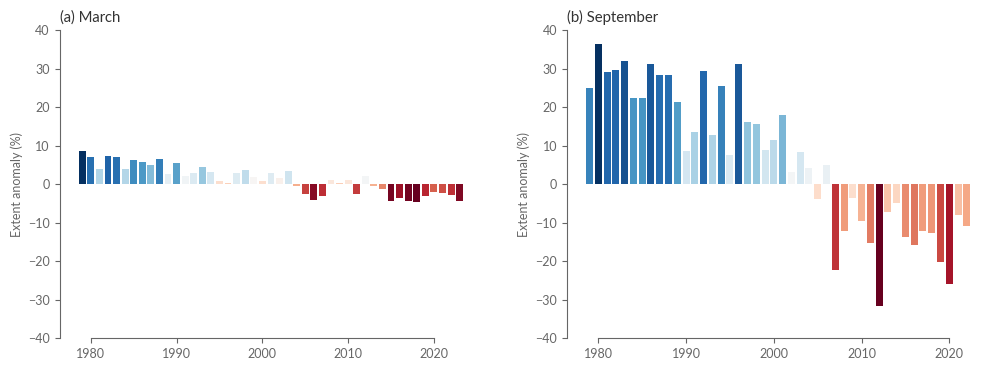

In [7]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns 
from string import ascii_lowercase as ABC 

subtitles = ['March', 'September']
cmap = sns.color_palette('RdBu', as_cmap=True)

norm_march = mcolors.Normalize(vmin=anom_march.min(), vmax=anom_march.max())
norm_september = mcolors.Normalize(vmin=anom_september.min(), vmax=anom_september.max())

clrs_march = [cmap(norm_march(val)) for val in anom_march.values]
clrs_september = [cmap(norm_september(val)) for val in anom_september.values]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(anom_march.time.dt.year, anom_march, color=clrs_march)
axes[1].bar(anom_september.time.dt.year, anom_september, color=clrs_september)
for ax, abc, title in zip(axes, ABC, subtitles):
    # ax.set_xticks(anom_march.time.dt.year[::5])
    # ax.set_xticklabels(anom_march.time.dt.year[::5])
    ax.set_ylim(-40, 40)
    ax.set_ylabel('Extent anomaly (%)')
    ax.set_xlabel('')
    ax.set_title('({}) {}'.format(abc, title))
    sns.despine(ax=ax, trim=True)

# Sea ice concentration

In [8]:
import cads_toolbox
request = [
   "satellite-sea-ice-concentration",
   {
        'version': 'v2',
        'variable': 'all',
        'format': 'zip',
        'origin': 'eumetsat_osi_saf',
        'region': 'northern_hemisphere',
        'cdr_type': [
            'cdr', 'icdr',
        ],
        'year': list(range(1979, 2023)),
        'month': '09',
        'day': [
            # '01', '02', '03',
            # '04', '05', '06',
            '07',
        ],
   }
]
remote = cads_toolbox.catalogue.retrieve(*request)
data = remote.to_xarray()
data = data.compute()
sic = data['ice_conc']

2023-05-22 22:46:32,505 INFO Welcome to the CDS
2023-05-22 22:46:32,509 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-sea-ice-concentration
2023-05-22 22:46:32,625 INFO Request is completed
2023-05-22 22:46:32,627 INFO Downloading https://download-0021.copernicus-climate.eu/cache-compute-0021/cache/data5/dataset-satellite-sea-ice-concentration-35962341-3dbe-4b63-9b9f-203794c4905e.zip to dataset-satellite-sea-ice-concentration-35962341-3dbe-4b63-9b9f-203794c4905e.zip (45.4M)
2023-05-22 22:47:05,365 INFO Download rate 1.4M/s   


In [10]:
sic

<xarray.DataArray 'ice_conc' (time: 40, yc: 432, xc: 432)>
array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
...
        ...,
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan]],

       [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan],
        [ 0.,  0.,  0., ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1979-09-07T12:00:00 ... 2022-09-07T12:00:00
  * xc       (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc       (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
    lat      (time, yc, xc) float32 16.62 16.82 17.02 ... 17.02 16.82 16.62
    lon      (yc, xc) float32 -135.0 -135.1 -135.3 -135.4 ... 44.73 44.87 45.0
Attributes:
    long_name:            fully filtered concentration of sea ice using atmos...
    standard_name:        sea_ice_area_fraction
    units:                %
    valid_min:            0
    valid_max:            10000
    grid_mapping:         Lambert_Azimuthal_Grid
    ancillary_variables:  total_standard_error status_flag
    comment:              this field is the primary sea ice concentration est...

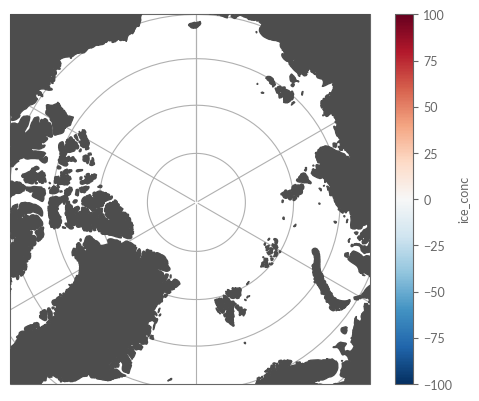

In [50]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
proj_polar = ccrs.NearsidePerspective(central_latitude=90, satellite_height=15785831)
proj_data = ccrs.LambertAzimuthalEqualArea(central_longitude=0, central_latitude=90)
diff = (sic.isel(time=-1) - sic.isel(time=0))

ax = plt.axes(projection=proj_polar)
ax.add_feature(cfeature.LAND, zorder=10, color='.3')
# ax.coastlines(zorder=10, color='r')
ax.set_extent([-180, 180, 70, 90], crs=ccrs.PlateCarree())

diff.plot.pcolormesh(ax=ax, zorder=50, cmap=plt.cm.RdBu_r, transform=proj_data)
ax.gridlines()


Somehow I cannot make the projections work.... I can plot land or the data, but not both. Do you see the error @NikosMastrantonas

# Sea ice edge type

In [245]:

request = [
   "satellite-sea-ice-edge-type",
   {
        'variable': 'sea_ice_edge',
        'region': 'northern_hemisphere',
        'cdr_type': 'cdr',
        'product_type': 'reanalysis',
        'year': list(range(1979, 2021)),
        'month': '03',
        'day': [
            '01', '02', '03',
            '04', '05', '06',
            '07',
        ],
        'version': '2_0',
        'time': '12:00',
        'format': 'zip',
   }
]
remote = cads_toolbox.catalogue.retrieve(*request)


In [247]:

da = remote.to_xarray()


2023-05-22 21:40:50,900 INFO Welcome to the CDS
2023-05-22 21:40:50,901 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-sea-ice-edge-type
2023-05-22 21:40:51,052 INFO Request is completed
2023-05-22 21:40:51,054 INFO Downloading https://download-0014-clone.copernicus-climate.eu/cache-compute-0014/cache/data6/dataset-satellite-sea-ice-edge-type-42a3a038-7a42-4ce7-be94-43a9c6e54e7f.zip to dataset-satellite-sea-ice-edge-type-42a3a038-7a42-4ce7-be94-43a9c6e54e7f.zip (28.6M)
2023-05-22 21:41:07,084 INFO Download rate 1.8M/s   


In [250]:
edge = da['ice_edge'].compute()


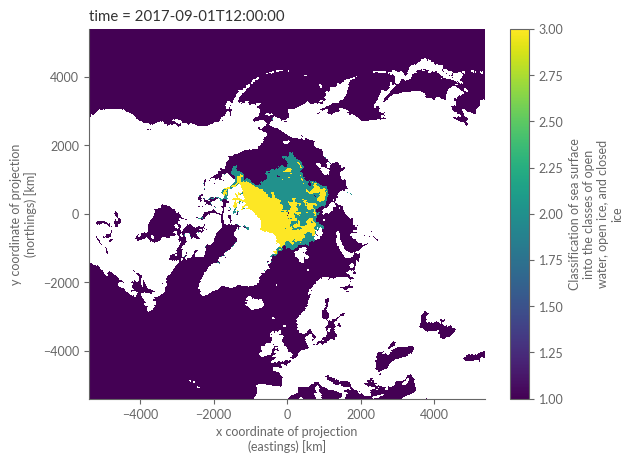

In [252]:
edge.isel(time=0).plot()